In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

## Data Preprocessing

In [2]:
class TransliterationDataset(Dataset):
    def __init__(self, file_path, source_vocab=None, target_vocab=None, max_length=32, create_vocab=False):
        # Attempt to read tab-separated file containing native and romanized text
        try:
            data = pd.read_csv(file_path, sep='\t', header=None,
                               names=['native', 'roman', 'freq'],
                               usecols=[0, 1], dtype=str)
            print(f"Loaded {len(data)} records from {file_path}")

            # Replace missing entries with empty strings
            data['native'] = data['native'].fillna('')
            data['roman'] = data['roman'].fillna('')

            # Create input-output text pairs for transliteration
            self.data_pairs = list(zip(data['roman'], data['native']))
            print(f"Example pairs: {self.data_pairs[:2]}")
        except Exception as err:
            print(f"Failed to load data: {err}")
            self.data_pairs = [('', '')]  # Fallback entry

        self.max_length = max_length

        # Initialize or use existing vocabulary mappings
        if create_vocab:
            self.source_vocab = {'<pad>': 0, '<unk>': 1, '<sos>':2, '<eos>':3}
            self.target_vocab = {'<pad>': 0, '<unk>': 1, '<sos>':2, '<eos>':3}
            self._generate_vocab()
        else:
            self.source_vocab, self.target_vocab = source_vocab, target_vocab
            if '<eos>' not in self.source_vocab:
                self.source_vocab['<eos>'] = len(self.source_vocab)
            if '<eos>' not in self.target_vocab:
                self.target_vocab['<eos>'] = len(self.target_vocab)

    def _generate_vocab(self):
        # Create vocabularies at the character level from the dataset
        for src_text, tgt_text in self.data_pairs:
            for char in src_text:
                if char not in self.source_vocab:
                    self.source_vocab[char] = len(self.source_vocab)
            for char in tgt_text:
                if char not in self.target_vocab:
                    self.target_vocab[char] = len(self.target_vocab)
        print(f"Vocab sizes — Source: {len(self.source_vocab)}, Target: {len(self.target_vocab)}")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        src_seq, tgt_seq = self.data_pairs[idx]
        
        # Convert characters to indices with bounds checking
        src_idxs = [self.source_vocab['<sos>']]  # Start with SOS token
        for ch in src_seq:
            idx = self.source_vocab.get(ch, self.source_vocab['<unk>'])
            if idx >= len(self.source_vocab):
                idx = self.source_vocab['<unk>']  # Safety check
            src_idxs.append(idx)
            
        tgt_idxs = [self.target_vocab['<sos>']]  # Start with SOS token
        for ch in tgt_seq:
            idx = self.target_vocab.get(ch, self.target_vocab['<unk>'])
            if idx >= len(self.target_vocab):
                idx = self.target_vocab['<unk>']  # Safety check
            tgt_idxs.append(idx)
        
        # Add end-of-sequence token
        src_idxs.append(self.source_vocab['<eos>'])
        tgt_idxs.append(self.target_vocab['<eos>'])
        
        # Add padding
        pad_src = [self.source_vocab['<pad>']] * max(0, self.max_length - len(src_idxs))
        pad_tgt = [self.target_vocab['<pad>']] * max(0, self.max_length - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_idxs = (src_idxs + pad_src)[:self.max_length]
        tgt_idxs = (tgt_idxs + pad_tgt)[:self.max_length]
        
        # Make sure padding index is valid
        assert self.source_vocab['<pad>'] < len(self.source_vocab), "Padding index out of bounds for source vocab"
        assert self.target_vocab['<pad>'] < len(self.target_vocab), "Padding index out of bounds for target vocab"
        
        return torch.tensor(src_idxs, dtype=torch.long), torch.tensor(tgt_idxs, dtype=torch.long)

## Seq2Seq Model with Attention

In [3]:
class BahdanauAttention(nn.Module):
    """Bahdanau attention mechanism (additive attention)"""
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Define trainable parameters for attention mechanism
        self.W_a = nn.Linear(hidden_size * 2, hidden_size)
        self.v_a = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, query, keys):
        """
        Args:
            query: decoder hidden state [batch_size, hidden_size]
            keys: encoder outputs [batch_size, src_len, hidden_size]
        Returns:
            context: context vector [batch_size, hidden_size]
            attention_weights: attention weights [batch_size, src_len]
        """
        batch_size, src_len, _ = keys.size()
        
        # Reshape query to [batch_size, 1, hidden_size] to match keys dimensions
        query = query.unsqueeze(1).repeat(1, src_len, 1)
        
        # Concatenate query and keys
        # [batch_size, src_len, hidden_size * 2]
        energy_input = torch.cat((query, keys), dim=2)
        
        # Calculate energy [batch_size, src_len, hidden_size]
        energy = torch.tanh(self.W_a(energy_input))
        
        # Calculate attention scores [batch_size, src_len, 1]
        attention = self.v_a(energy)
        
        # Remove last dimension and apply softmax
        # [batch_size, src_len]
        attention_weights = F.softmax(attention.squeeze(2), dim=1)
        
        # Calculate weighted sum of encoder outputs (context vector)
        # [batch_size, 1, src_len] x [batch_size, src_len, hidden_size] -> [batch_size, 1, hidden_size]
        context = torch.bmm(attention_weights.unsqueeze(1), keys)
        
        # Remove dimension 1 -> [batch_size, hidden_size]
        context = context.squeeze(1)
        
        return context, attention_weights

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_vocab_size, embedding_size, hidden_size, num_layers, dropout=0.0, cell_type='GRU'):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        
        # Choose appropriate RNN cell
        if cell_type == 'RNN':
            rnn_cell = nn.RNN
        elif cell_type == 'GRU':
            rnn_cell = nn.GRU
        elif cell_type == 'LSTM':
            rnn_cell = nn.LSTM
        else:
            raise ValueError(f"RNN type not recognized: {cell_type}")
        
        self.rnn = rnn_cell(
            embedding_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
    
    def forward(self, x):
        """
        Args:
            x: input sequence [batch_size, seq_len]
        Returns:
            outputs: encoder outputs [batch_size, seq_len, hidden_size]
            hidden: final hidden state [num_layers, batch_size, hidden_size]
        """
        # Apply embedding layer: [batch_size, seq_len] -> [batch_size, seq_len, embedding_size]
        embedded = self.embedding(x)
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        return outputs, hidden

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, output_vocab_size, embedding_size, hidden_size, num_layers, dropout=0.0, cell_type='GRU'):
        super().__init__()
        self.output_vocab_size = output_vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        
        self.embedding = nn.Embedding(output_vocab_size, embedding_size, padding_idx=0)
        
        # Attention mechanism
        self.attention = BahdanauAttention(hidden_size)
        
        # For concatenating embedding and context vector
        self.rnn_input_size = embedding_size + hidden_size
        
        # Choose appropriate RNN cell
        if cell_type == 'RNN':
            rnn_cell = nn.RNN
        elif cell_type == 'GRU':
            rnn_cell = nn.GRU
        elif cell_type == 'LSTM':
            rnn_cell = nn.LSTM
        else:
            raise ValueError(f"RNN type not recognized: {cell_type}")
        
        self.rnn = rnn_cell(
            self.rnn_input_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        # Linear layer to produce output logits
        self.output_projection = nn.Linear(hidden_size * 2, output_vocab_size)
    
    def forward(self, input_token, last_hidden, encoder_outputs):
        """
        Args:
            input_token: input token indices [batch_size, 1]
            last_hidden: previous decoder hidden state
            encoder_outputs: encoder outputs [batch_size, src_len, hidden_size]
        Returns:
            output: output logits [batch_size, output_vocab_size]
            hidden: new hidden state
            attn_weights: attention weights [batch_size, src_len]
        """
        # Get embedding for input token [batch_size, 1, embedding_size]
        embedded = self.embedding(input_token)
        
        # Get current hidden state to use for attention
        if self.cell_type == 'LSTM':
            current_hidden = last_hidden[0][-1]  # Use the last layer's hidden state
        else:
            current_hidden = last_hidden[-1]  # Use the last layer's hidden state
        
        # Apply attention mechanism
        context, attn_weights = self.attention(current_hidden, encoder_outputs)
        
        # Combine embedding and context vector [batch_size, 1, embedding_size + hidden_size]
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
        
        # Pass through RNN
        output, hidden = self.rnn(rnn_input, last_hidden)
        
        # Combine RNN output with context vector for better prediction
        output = torch.cat((output.squeeze(1), context), dim=1)
        
        # Project to vocabulary space [batch_size, output_vocab_size]
        output = self.output_projection(output)
        
        return output, hidden, attn_weights

In [6]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, config, input_vocab_size, output_vocab_size):
        super().__init__()

        # Ensure vocabulary sizes are positive
        assert input_vocab_size > 0, f"Source vocab size invalid: {input_vocab_size}"
        assert output_vocab_size > 0, f"Target vocab size invalid: {output_vocab_size}"

        # Hyperparameter setup
        self.embedding_size = config.embed_dim
        self.hidden_size = config.hidden_dim
        self.rnn_type = config.cell_type
        self.encoder_layers = config.num_layers
        self.decoder_layers = config.num_layers
        
        # Initialize encoder and decoder
        self.encoder = EncoderRNN(
            input_vocab_size, 
            config.embed_dim, 
            config.hidden_dim, 
            config.num_layers, 
            config.dropout, 
            config.cell_type
        )
        
        self.decoder = DecoderRNN(
            output_vocab_size, 
            config.embed_dim, 
            config.hidden_dim, 
            config.num_layers, 
            config.dropout, 
            config.cell_type
        )
        
        # For accessing embeddings in training/inference
        self.input_embedding = self.encoder.embedding
        self.output_embedding = self.decoder.embedding

        print(f"Initialized model with attention: {self.rnn_type}, Encoder layers: {self.encoder_layers}, "
              f"Decoder layers: {self.decoder_layers}, Embedding: {self.embedding_size}, Hidden: {self.hidden_size}")

    def forward(self, source_seq, target_seq):
        """
        Forward pass through the entire seq2seq model.
        
        Args:
            source_seq: source sequence [batch_size, src_len]
            target_seq: target sequence [batch_size, tgt_len]
        
        Returns:
            outputs: output logits [batch_size, tgt_len-1, output_vocab_size]
        """
        batch_size, tgt_len = target_seq.size()
        device = source_seq.device

        # Index range check and clamping
        if source_seq.max() >= self.input_embedding.num_embeddings:
            print("Warning: Source index out of bounds")
            source_seq = torch.clamp(source_seq, 0, self.input_embedding.num_embeddings - 1)
        if target_seq.max() >= self.output_embedding.num_embeddings:
            print("Warning: Target index out of bounds")
            target_seq = torch.clamp(target_seq, 0, self.output_embedding.num_embeddings - 1)

        try:
            # Encode source sequence
            encoder_outputs, encoder_hidden = self.encoder(source_seq)
            
            # Initialize decoder hidden state with encoder final state
            decoder_hidden = encoder_hidden
            
            # Teacher forcing: feed target as the next input
            decoder_input = target_seq[:, :-1]  # Input: from <sos> to the second-to-last token
            # Store all decoder outputs
            outputs = torch.zeros(batch_size, tgt_len-1, self.decoder.output_vocab_size, device=device)
            
            # Process one token at a time
            for t in range(tgt_len-1):
                # Get token for current timestep
                current_input = target_seq[:, t].unsqueeze(1)
                
                # Forward through decoder
                decoder_output, decoder_hidden, _ = self.decoder(
                    current_input,
                    decoder_hidden,
                    encoder_outputs
                )
                
                # Store prediction
                outputs[:, t, :] = decoder_output
            
            return outputs
            
        except Exception as err:
            print(f"Forward pass exception: {err}")
            return torch.zeros(batch_size, tgt_len-1, self.decoder.output_vocab_size, device=device)

    def inference(self, source_seq, max_length=50, beam_size=1):
        """
        Generate transliteration using beam search.
        
        Args:
            source_seq: source sequence [batch_size, src_len]
            max_length: maximum length of generated sequence
            beam_size: beam size for beam search
            
        Returns:
            generated_seq: generated sequence [batch_size, max_length]
        """
        batch_size = source_seq.size(0)
        device = source_seq.device
        
        # Encode source sequence
        encoder_outputs, encoder_hidden = self.encoder(source_seq)
        
        if beam_size == 1:
            # Greedy search
            decoder_hidden = encoder_hidden
            decoder_input = torch.tensor([[2]], device=device).repeat(batch_size, 1)  # Start with <sos> token
            generated_tokens = torch.zeros(batch_size, max_length, dtype=torch.long, device=device)

            # Store attention weights for each step
            attention_weights = torch.zeros(batch_size, max_length, source_seq.size(1), device=device)
            
            for t in range(max_length):
                # Forward through decoder
                decoder_output, decoder_hidden, attn_weights = self.decoder(
                    decoder_input,
                    decoder_hidden,
                    encoder_outputs
                )
                
                # Get most likely token
                _, topi = decoder_output.topk(1)
                decoder_input = topi.view(batch_size, 1)
                
                # Save generated token
                generated_tokens[:, t] = decoder_input.squeeze(1)

                # Save attention weights
                attention_weights[:, t, :] = attn_weights
                
                # Stop if all sequences generated <eos>
                if (decoder_input == 3).all():  # 3 is <eos> token index
                    break
            
            return generated_tokens, attention_weights
        else:
            # Implement beam search here (omitted for brevity)
            # For now, return greedy search result
            return self.inference(source_seq, max_length, beam_size=1)

In [7]:
def compute_accuracy(logits, target, pad_idx=0):
    """
    Computes accuracy excluding padding tokens.
    """
    preds = logits.argmax(dim=-1)
    mask = target != pad_idx
    correct = (preds == target) & mask
    acc = correct.sum().item() / max(mask.sum().item(), 1)  # Avoid division by zero
    return acc

In [8]:
def run_epoch(model, data_loader, loss_fn, optim, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_batches = len(data_loader)
    processed_batches = 0

    for i, (inputs, targets) in enumerate(data_loader):
        try:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Check for out-of-vocabulary token indices
            if inputs.max().item() >= model.input_embedding.num_embeddings or \
               targets.max().item() >= model.output_embedding.num_embeddings:
                print(f"Skipping batch {i}/{total_batches} - "
                      f"Input max: {inputs.max().item()}, Target max: {targets.max().item()}, "
                      f"Input vocab size: {model.input_embedding.num_embeddings}, "
                      f"Target vocab size: {model.output_embedding.num_embeddings}")
                continue

            # Reset gradients
            optim.zero_grad()

            # Model inference
            output_logits = model(inputs, targets)

            # Flatten predictions and targets for loss function
            pred_flat = output_logits.reshape(-1, output_logits.size(-1))
            true_flat = targets[:, 1:].reshape(-1)  # Shift targets by one for teacher forcing

            # Compute loss and perform optimization
            loss = loss_fn(pred_flat, true_flat)
            loss.backward()
            
            # Apply gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optim.step()

            total_loss += loss.item()
                
            # Accuracy
            acc = compute_accuracy(output_logits, targets[:, 1:])
            total_acc += acc
            processed_batches += 1

        except Exception as err:
            print(f"Error in batch {i}/{total_batches}: {err}")
            continue

    if processed_batches == 0:
        return 0.0, 0.0
    return total_loss / processed_batches, total_acc / processed_batches

In [9]:
def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    processed_batches = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            try:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Ensure token indices are within valid vocabulary range
                if inputs.max() >= model.input_embedding.num_embeddings or \
                   targets.max() >= model.output_embedding.num_embeddings:
                    continue  # Skip batch if invalid indices found

                # Forward propagation
                predictions = model(inputs, targets)

                # Flatten tensors for loss calculation
                pred_flat = predictions.reshape(-1, predictions.size(-1))
                target_flat = targets[:, 1:].reshape(-1)  # Shift targets by one for teacher forcing

                # Compute batch loss
                loss = loss_fn(pred_flat, target_flat)
                total_loss += loss.item()
                
                # Compute accuracy
                acc = compute_accuracy(predictions, targets[:, 1:])
                total_acc += acc
                processed_batches += 1

            except Exception as ex:
                print(f"Evaluation error: {ex}")
                continue

    if processed_batches == 0:
        return 0.0, 0.0
    return total_loss / processed_batches, total_acc / processed_batches

## Sweeps

In [10]:
def export_vocabularies(directory, source_dict, target_dict):
    """Export source and target vocabularies to JSON format."""
    os.makedirs(directory, exist_ok=True)
    
    src_path = os.path.join(directory, 'src.json')
    tgt_path = os.path.join(directory, 'tgt.json')
    
    with open(src_path, 'w', encoding='utf-8') as src_file:
        json.dump(source_dict, src_file, indent=2, ensure_ascii=False)
        
    with open(tgt_path, 'w', encoding='utf-8') as tgt_file:
        json.dump(target_dict, tgt_file, indent=2, ensure_ascii=False)

def import_vocabularies(directory):
    """Import source and target vocabularies from JSON files."""
    with open(os.path.join(directory, 'src.json'), 'r', encoding='utf-8') as src_file:
        source_dict = json.load(src_file)
        
    with open(os.path.join(directory, 'tgt.json'), 'r', encoding='utf-8') as tgt_file:
        target_dict = json.load(tgt_file)
        
    return source_dict, target_dict

In [11]:
# Dataset paths
path_train = '/kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv'
path_dev = '/kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv'
vocab_dir = '/kaggle/working/vocab'

print("Generating vocabularies...")
train_data = TransliterationDataset(path_train, create_vocab=True)
src_vocab, tgt_vocab = train_data.source_vocab, train_data.target_vocab

export_vocabularies(vocab_dir, src_vocab, tgt_vocab)
print(f"Source vocab: {len(src_vocab)}, Target vocab: {len(tgt_vocab)}")

# Display sample vocab entries
print("Source vocab sample:")
for ch, idx in list(src_vocab.items())[:10]:
    print(f"  {repr(ch)} => {idx}")
print("Target vocab sample:")
for ch, idx in list(tgt_vocab.items())[:10]:
    print(f"  {repr(ch)} => {idx}")

Generating vocabularies...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Vocab sizes — Source: 30, Target: 67
Source vocab: 30, Target vocab: 67
Source vocab sample:
  '<pad>' => 0
  '<unk>' => 1
  '<sos>' => 2
  '<eos>' => 3
  'a' => 4
  'm' => 5
  'k' => 6
  'i' => 7
  't' => 8
  'n' => 9
Target vocab sample:
  '<pad>' => 0
  '<unk>' => 1
  '<sos>' => 2
  '<eos>' => 3
  'అ' => 4
  'ం' => 5
  'క' => 6
  'ి' => 7
  'త' => 8
  'భ' => 9


In [12]:
def run_sweep():
    """Function to run for each sweep configuration"""
    run = wandb.init()
    cfg = run.config
        
    # Create a descriptive run name
    run.name = f"{cfg.cell_type}-e{cfg.embed_dim}-h{cfg.hidden_dim}-enc{cfg.num_layers}-dec{cfg.num_layers}-d{cfg.dropout}-lr{cfg.learning_rate}-b{cfg.batch_size}-beam{cfg.beam_size}"
        
    # Set device - force CPU initially if CUDA issues were detected
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 10
    
    # Load vocabularies
    try:
        src_vocab, tgt_vocab = import_vocabularies(vocab_dir)
        print(f"Loaded vocabularies: Source: {len(src_vocab)}, Target: {len(tgt_vocab)}")
    except Exception as e:
        print(f"Error loading vocabularies: {e}")
        print("Generating vocabularies...")
        train_data = TransliterationDataset(path_train, create_vocab=True)
        src_vocab, tgt_vocab = train_data.source_vocab, train_data.target_vocab
        export_vocabularies(vocab_dir, src_vocab, tgt_vocab)
    
    # Initialize model
    try:
        # First create on CPU
        model = Seq2SeqWithAttention(cfg, len(src_vocab), len(tgt_vocab))
        print("Model created on CPU, trying to move to device...")
        # Then try to move to target device
        model = model.to(device)
        print("Model successfully moved to device.")
    except Exception as e:
        print(f"Error initializing model on {device}: {e}")
        print("Falling back to CPU")
        device = torch.device('cpu')
        model = Seq2SeqWithAttention(cfg, len(src_vocab), len(tgt_vocab)).to(device)
        
    # Load datasets
    try:
        print("Loading datasets...")
        train_dataset = TransliterationDataset(path_train, src_vocab, tgt_vocab)
        dev_dataset = TransliterationDataset(path_dev, src_vocab, tgt_vocab)
            
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
        dev_loader = DataLoader(dev_dataset, batch_size=cfg.batch_size)
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return
        
    # Initialize loss function and optimizer
    try:
        criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
        optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
    except Exception as e:
        print(f"Error initializing criterion or optimizer: {e}")
        return
        
    # Training loop
    best_val_acc = 0.0
        
    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
                
            # Training
            train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device)
            print(f"Train loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
                
            # Validation
            val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
            print(f"Validation loss: {val_loss:.4f} Validation Accuracy: {val_acc:.4f} ")
            
            # Update learning rate
            scheduler.step(val_loss)
                
            # Log metrics
            wandb.log({
                'train_loss': train_loss, 
                'val_loss': val_loss, 
                'train_acc': train_acc, 
                'val_acc': val_acc, 
                'epoch': epoch
            })
                
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                print(f"New best model with validation accuracy: {best_val_acc:.4f}")
                
        wandb.log({'val_accuracy': best_val_acc})
        
                    
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

In [14]:
# Configure sweep 
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'cell_type': {'values': ['RNN', 'LSTM', 'GRU']},
        'embed_dim': {'values': [64, 128, 256]},
        'hidden_dim': {'values': [256, 512]},
        'num_layers': {'values': [1, 2, 3]},
        'dropout': {'values': [0.0, 0.1, 0.2]},
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'batch_size': {'values': [32, 64, 128]},
        'beam_size': {'values': [1, 3, 5]}
    }
}

In [12]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

In [13]:
wandb.login(key = secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m027 (da24m027-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [17]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment3")

Create sweep with ID: 5wn74dk6
Sweep URL: https://wandb.ai/da24m027-indian-institute-of-technology-madras/DA6401_Assignment3/sweeps/5wn74dk6


In [ ]:
wandb.agent(sweep_id, run_sweep, count=20)

wandb: Agent Starting Run: 7cpnh3tf with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: RNN, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
Train loss: 0.9981 Train Accuracy: 0.7302
Validation loss: 0.4434 Validation Accuracy: 0.8684 
New best model with validation accuracy: 0.8684
Epoch 2/10
Train loss: 0.3339 Train Accuracy: 0.9007
Validation loss: 0.3184 Validation Accuracy: 0.9019 
New best model with validation accuracy: 0.9019
Epoch 3/10
Train loss: 0.2499 Train Accuracy: 0.9244
Validation loss: 0.2726 Validation Accuracy: 0.9161 
New best model with validation accuracy: 0.9161
Epoch 4/10
Train loss: 0.2070 Train Accuracy: 0.9372
Validation loss: 0.2655 Validation Accuracy: 0.9195 
New best model with validation accuracy: 0.9195
Epoch 5/10
Train loss: 0.1785 Train Accuracy: 0.9457
Validation loss: 0.2574 Validation Accuracy: 0.9203 
New best model with validation accuracy: 0.9203
Epoch 6/10
Train loss: 0.1564 Train Accuracy: 0.9520
Validation loss: 0.2499 Validation Accuracy: 0.9255 
New best model with validation accuracy: 0.9255
Epoch 7/10
Train loss: 0.1394 Train Accuracy: 0.9573
Validation loss: 0.2518

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇█████
val_accuracy,▁
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,9
train_acc,0.96838
train_loss,0.10129
val_acc,0.92927
val_accuracy,0.92927


wandb: Agent Starting Run: uagvipbb with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 1


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: RNN, Encoder layers: 1, Decoder layers: 1, Embedding: 128, Hidden: 256
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.8628 Train Accuracy: 0.7614
Validation loss: 0.4077 Validation Accuracy: 0.8755 
New best model with validation accuracy: 0.8755
Epoch 2/10
Train loss: 0.3361 Train Accuracy: 0.8985
Validation loss: 0.3445 Validation Accuracy: 0.8925 
New best model with validation accuracy: 0.8925
Epoch 3/10
Train loss: 0.2631 Train Accuracy: 0.9198
Validation loss: 0.3047 Validation Accuracy: 0.9052 
New best model with validation accuracy: 0.9052
Epoch 4/10
Train loss: 0.2253 Train Accuracy: 0.9316
Validation loss: 0.2926 Validation Accuracy: 0.9107 
New best model with validation accuracy: 0.9107
Epoch 5/10
Train loss: 0.1974 Train Accuracy: 0.9403
Validation loss: 0.2929 Validation Accuracy: 0.9126 
New best model with validation accuracy: 0.9126
Epoch 6/10
Train loss: 0.1772 Train Accuracy: 0.9461
Validation loss: 0.2720 Validation Accuracy: 0.9177 
New best model with validation accuracy: 0.9177
Epoch 7/10
Train loss: 0.1606 Train Accuracy: 0.9509
Validation loss: 0.2847 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇█
val_accuracy,▁
val_loss,█▅▃▂▂▁▂▁▂▁
epoch,9
train_acc,0.96752
train_loss,0.10884
val_acc,0.92356
val_accuracy,0.92356


wandb: Agent Starting Run: bubbxn7v with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 1


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: RNN, Encoder layers: 1, Decoder layers: 1, Embedding: 128, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1072 Train Accuracy: 0.7086
Validation loss: 0.5166 Validation Accuracy: 0.8509 
New best model with validation accuracy: 0.8509
Epoch 2/10
Train loss: 0.4176 Train Accuracy: 0.8783
Validation loss: 0.3826 Validation Accuracy: 0.8869 
New best model with validation accuracy: 0.8869
Epoch 3/10
Train loss: 0.3099 Train Accuracy: 0.9086
Validation loss: 0.3308 Validation Accuracy: 0.9004 
New best model with validation accuracy: 0.9004
Epoch 4/10
Train loss: 0.2607 Train Accuracy: 0.9229
Validation loss: 0.3126 Validation Accuracy: 0.9054 
New best model with validation accuracy: 0.9054
Epoch 5/10
Train loss: 0.2272 Train Accuracy: 0.9329
Validation loss: 0.2914 Validation Accuracy: 0.9123 
New best model with validation accuracy: 0.9123
Epoch 6/10
Train loss: 0.2015 Train Accuracy: 0.9403
Validation loss: 0.2843 Validation Accuracy: 0.9145 
New best model with validation accuracy: 0.9145
Epoch 7/10
Train loss: 0.1806 Train Accuracy: 0.9466
Validation loss: 0.2843 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▆▇▇████
val_accuracy,▁
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,9
train_acc,0.95984
train_loss,0.13545
val_acc,0.91861
val_accuracy,0.9208


wandb: Agent Starting Run: k3zngger with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: RNN, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.2067 Train Accuracy: 0.6846
Validation loss: 0.4858 Validation Accuracy: 0.8583 
New best model with validation accuracy: 0.8583
Epoch 2/10
Train loss: 0.4284 Train Accuracy: 0.8757
Validation loss: 0.3731 Validation Accuracy: 0.8899 
New best model with validation accuracy: 0.8899
Epoch 3/10
Train loss: 0.3219 Train Accuracy: 0.9052
Validation loss: 0.3154 Validation Accuracy: 0.9044 
New best model with validation accuracy: 0.9044
Epoch 4/10
Train loss: 0.2707 Train Accuracy: 0.9194
Validation loss: 0.2957 Validation Accuracy: 0.9103 
New best model with validation accuracy: 0.9103
Epoch 5/10
Train loss: 0.2375 Train Accuracy: 0.9291
Validation loss: 0.2815 Validation Accuracy: 0.9147 
New best model with validation accuracy: 0.9147
Epoch 6/10
Train loss: 0.2124 Train Accuracy: 0.9364
Validation loss: 0.2729 Validation Accuracy: 0.9180 
New best model with validation accuracy: 0.9180
Epoch 7/10
Train loss: 0.1924 Train Accuracy: 0.9420
Validation loss: 0.2600 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▆▇▇████
val_accuracy,▁
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,9
train_acc,0.95471
train_loss,0.14899
val_acc,0.92456
val_accuracy,0.92456


wandb: Agent Starting Run: z61aw7tc with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: LSTM, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.8913 Train Accuracy: 0.4790
Validation loss: 0.7479 Validation Accuracy: 0.7790 
New best model with validation accuracy: 0.7790
Epoch 2/10
Train loss: 0.4898 Train Accuracy: 0.8600
Validation loss: 0.3505 Validation Accuracy: 0.8955 
New best model with validation accuracy: 0.8955
Epoch 3/10
Train loss: 0.2996 Train Accuracy: 0.9111
Validation loss: 0.2950 Validation Accuracy: 0.9087 
New best model with validation accuracy: 0.9087
Epoch 4/10
Train loss: 0.2315 Train Accuracy: 0.9308
Validation loss: 0.2716 Validation Accuracy: 0.9172 
New best model with validation accuracy: 0.9172
Epoch 5/10
Train loss: 0.1907 Train Accuracy: 0.9429
Validation loss: 0.2559 Validation Accuracy: 0.9221 
New best model with validation accuracy: 0.9221
Epoch 6/10
Train loss: 0.1614 Train Accuracy: 0.9514
Validation loss: 0.2571 Validation Accuracy: 0.9250 
New best model with validation accuracy: 0.9250
Epoch 7/10
Train loss: 0.1382 Train Accuracy: 0.9583
Validation loss: 0.2565 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▆▇▇██████
val_accuracy,▁
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,9
train_acc,0.97222
train_loss,0.09098
val_acc,0.92942
val_accuracy,0.92942


wandb: Agent Starting Run: zefseocn with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9650 Train Accuracy: 0.7358
Validation loss: 0.3924 Validation Accuracy: 0.8822 
New best model with validation accuracy: 0.8822
Epoch 2/10
Train loss: 0.3123 Train Accuracy: 0.9071
Validation loss: 0.3086 Validation Accuracy: 0.9058 
New best model with validation accuracy: 0.9058
Epoch 3/10
Train loss: 0.2345 Train Accuracy: 0.9294
Validation loss: 0.2727 Validation Accuracy: 0.9153 
New best model with validation accuracy: 0.9153
Epoch 4/10
Train loss: 0.1907 Train Accuracy: 0.9422
Validation loss: 0.2504 Validation Accuracy: 0.9234 
New best model with validation accuracy: 0.9234
Epoch 5/10
Train loss: 0.1610 Train Accuracy: 0.9513
Validation loss: 0.2446 Validation Accuracy: 0.9272 
New best model with validation accuracy: 0.9272
Epoch 6/10
Train loss: 0.1369 Train Accuracy: 0.9585
Validation loss: 0.2474 Validation Accuracy: 0.9260 
Epoch 7/10
Train loss: 0.1176 Train Accuracy: 0.9642
Validation loss: 0.2476 Validation Accuracy: 0.9292 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_accuracy,▁
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,9
train_acc,0.97926
train_loss,0.06795
val_acc,0.93002
val_accuracy,0.93199


wandb: Agent Starting Run: uavol62u with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 256
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 2.4852 Train Accuracy: 0.3431
Validation loss: 1.6318 Validation Accuracy: 0.5642 
New best model with validation accuracy: 0.5642
Epoch 2/10
Train loss: 1.1526 Train Accuracy: 0.6934
Validation loss: 0.7369 Validation Accuracy: 0.8016 
New best model with validation accuracy: 0.8016
Epoch 3/10
Train loss: 0.6052 Train Accuracy: 0.8357
Validation loss: 0.5033 Validation Accuracy: 0.8555 
New best model with validation accuracy: 0.8555
Epoch 4/10
Train loss: 0.4422 Train Accuracy: 0.8740
Validation loss: 0.4384 Validation Accuracy: 0.8686 
New best model with validation accuracy: 0.8686
Epoch 5/10
Train loss: 0.3680 Train Accuracy: 0.8926
Validation loss: 0.3718 Validation Accuracy: 0.8876 
New best model with validation accuracy: 0.8876
Epoch 6/10
Train loss: 0.3182 Train Accuracy: 0.9063
Validation loss: 0.3394 Validation Accuracy: 0.8975 
New best model with validation accuracy: 0.8975
Epoch 7/10
Train loss: 0.2842 Train Accuracy: 0.9165
Validation loss: 0.3213 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▇▇▇█████
train_loss,█▄▂▂▁▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_accuracy,▁
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,9
train_acc,0.93578
train_loss,0.21851
val_acc,0.91318
val_accuracy,0.91318


wandb: Agent Starting Run: qywy02p9 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.3173 Train Accuracy: 0.6457
Validation loss: 0.4768 Validation Accuracy: 0.8581 
New best model with validation accuracy: 0.8581
Epoch 2/10
Train loss: 0.3990 Train Accuracy: 0.8834
Validation loss: 0.3329 Validation Accuracy: 0.8959 
New best model with validation accuracy: 0.8959
Epoch 3/10
Train loss: 0.2912 Train Accuracy: 0.9127
Validation loss: 0.2909 Validation Accuracy: 0.9097 
New best model with validation accuracy: 0.9097
Epoch 4/10
Train loss: 0.2428 Train Accuracy: 0.9267
Validation loss: 0.2767 Validation Accuracy: 0.9147 
New best model with validation accuracy: 0.9147
Epoch 5/10
Train loss: 0.2102 Train Accuracy: 0.9360
Validation loss: 0.2595 Validation Accuracy: 0.9203 
New best model with validation accuracy: 0.9203
Epoch 6/10
Train loss: 0.1863 Train Accuracy: 0.9431
Validation loss: 0.2478 Validation Accuracy: 0.9229 
New best model with validation accuracy: 0.9229
Epoch 7/10
Train loss: 0.1662 Train Accuracy: 0.9491
Validation loss: 0.2432 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_accuracy,▁
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,9
train_acc,0.96292
train_loss,0.12134
val_acc,0.92931
val_accuracy,0.92932


wandb: Agent Starting Run: etfduh4h with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9573 Train Accuracy: 0.7396
Validation loss: 0.3839 Validation Accuracy: 0.8809 
New best model with validation accuracy: 0.8809
Epoch 2/10
Train loss: 0.3129 Train Accuracy: 0.9062
Validation loss: 0.3020 Validation Accuracy: 0.9071 
New best model with validation accuracy: 0.9071
Epoch 3/10
Train loss: 0.2358 Train Accuracy: 0.9286
Validation loss: 0.2648 Validation Accuracy: 0.9206 
New best model with validation accuracy: 0.9206
Epoch 4/10
Train loss: 0.1927 Train Accuracy: 0.9416
Validation loss: 0.2557 Validation Accuracy: 0.9214 
New best model with validation accuracy: 0.9214
Epoch 5/10
Train loss: 0.1619 Train Accuracy: 0.9504
Validation loss: 0.2512 Validation Accuracy: 0.9238 
New best model with validation accuracy: 0.9238
Epoch 6/10
Train loss: 0.1384 Train Accuracy: 0.9578
Validation loss: 0.2468 Validation Accuracy: 0.9243 
New best model with validation accuracy: 0.9243
Epoch 7/10
Train loss: 0.1190 Train Accuracy: 0.9634
Validation loss: 0.2459 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▇▇▇▇████
val_accuracy,▁
val_loss,█▄▂▁▁▁▁▁▁▂
epoch,9
train_acc,0.97554
train_loss,0.07855
val_acc,0.92969
val_accuracy,0.92995


wandb: Agent Starting Run: vsvm8umr with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9678 Train Accuracy: 0.7358
Validation loss: 0.3957 Validation Accuracy: 0.8806 
New best model with validation accuracy: 0.8806
Epoch 2/10
Train loss: 0.3139 Train Accuracy: 0.9066
Validation loss: 0.3089 Validation Accuracy: 0.9032 
New best model with validation accuracy: 0.9032
Epoch 3/10
Train loss: 0.2363 Train Accuracy: 0.9288
Validation loss: 0.2754 Validation Accuracy: 0.9128 
New best model with validation accuracy: 0.9128
Epoch 4/10
Train loss: 0.1938 Train Accuracy: 0.9411
Validation loss: 0.2663 Validation Accuracy: 0.9176 
New best model with validation accuracy: 0.9176
Epoch 5/10
Train loss: 0.1623 Train Accuracy: 0.9508
Validation loss: 0.2532 Validation Accuracy: 0.9239 
New best model with validation accuracy: 0.9239
Epoch 6/10
Train loss: 0.1381 Train Accuracy: 0.9578
Validation loss: 0.2489 Validation Accuracy: 0.9272 
New best model with validation accuracy: 0.9272
Epoch 7/10
Train loss: 0.1191 Train Accuracy: 0.9637
Validation loss: 0.2548 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▆▇██▇██
val_accuracy,▁
val_loss,█▄▂▂▁▁▁▂▁▁
epoch,9
train_acc,0.98006
train_loss,0.0659
val_acc,0.92911
val_accuracy,0.92911


wandb: Agent Starting Run: o8o7po1b with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.9866 Train Accuracy: 0.7298
Validation loss: 0.3835 Validation Accuracy: 0.8839 
New best model with validation accuracy: 0.8839
Epoch 2/10
Train loss: 0.3262 Train Accuracy: 0.9029
Validation loss: 0.2963 Validation Accuracy: 0.9072 
New best model with validation accuracy: 0.9072
Epoch 3/10
Train loss: 0.2455 Train Accuracy: 0.9256
Validation loss: 0.2664 Validation Accuracy: 0.9184 
New best model with validation accuracy: 0.9184
Epoch 4/10
Train loss: 0.2042 Train Accuracy: 0.9382
Validation loss: 0.2534 Validation Accuracy: 0.9220 
New best model with validation accuracy: 0.9220
Epoch 5/10
Train loss: 0.1743 Train Accuracy: 0.9468
Validation loss: 0.2412 Validation Accuracy: 0.9271 
New best model with validation accuracy: 0.9271
Epoch 6/10
Train loss: 0.1500 Train Accuracy: 0.9543
Validation loss: 0.2420 Validation Accuracy: 0.9256 
Epoch 7/10
Train loss: 0.1313 Train Accuracy: 0.9597
Validation loss: 0.2448 Validation Accuracy: 0.9271 
Epoch 8/10
Train loss: 0.1154

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇██
val_accuracy,▁
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,9
train_acc,0.97501
train_loss,0.08159
val_acc,0.93306
val_accuracy,0.93306


wandb: Agent Starting Run: ex0xumgj with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 29, Target: 66
Initialized model with attention: GRU, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.4434 Train Accuracy: 0.8687
Validation loss: 0.2893 Validation Accuracy: 0.9107 
New best model with validation accuracy: 0.9107
Epoch 2/10
Train loss: 0.2047 Train Accuracy: 0.9372
Validation loss: 0.2782 Validation Accuracy: 0.9192 
New best model with validation accuracy: 0.9192
Epoch 3/10
Train loss: 0.1669 Train Accuracy: 0.9490
Validation loss: 0.2920 Validation Accuracy: 0.9136 
Epoch 4/10
Train loss: 0.1489 Train Accuracy: 0.9541
Validation loss: 0.2837 Validation Accuracy: 0.9213 
New best model with validation accuracy: 0.9213
Epoch 5/10
Train loss: 0.1388 Train Accuracy: 0.9574
Validation loss: 0.2881 Validation Accuracy: 0.9201 
Epoch 6/10
Train loss: 0.0893 Train Accuracy: 0.9724
Validation loss: 0.2633 Validation Accuracy: 0.9304 
New best model with validation accuracy: 0.9304
Epoch 7/10
Train loss: 0.0676 Train Accuracy: 0.9789
Validation loss: 0.2762 Validation Accuracy: 0.9286 
Epoch 8/10
Train loss: 0.0607 Train Accuracy: 0.9808
Validation loss: 0.2850 

## Testing

In [14]:
api = wandb.Api()
sweep = api.sweep("da24m027-indian-institute-of-technology-madras/DA6401_Assignment3/5wn74dk6")
best_run = sweep.best_run()
best_run_config = best_run.config

wandb: Sorting runs by -summary_metrics.val_accuracy


In [15]:
best_run_config

{'dropout': 0.2,
 'beam_size': 3,
 'cell_type': 'GRU',
 'embed_dim': 256,
 'batch_size': 32,
 'hidden_dim': 512,
 'num_layers': 3,
 'learning_rate': 0.0001}

In [16]:
def decode_sequence(seq, char_vocab, end_token=3):
    """
    Convert index sequence to character sequence
    
    Args:
        seq: Sequence of indices
        char_vocab: Dictionary mapping characters to indices
        end_token: Token index representing end of sequence (default=2)
        
    Returns:
        String of characters
    """
    # Create inverse mapping (idx -> char)
    idx_to_char = {idx: ch for ch, idx in char_vocab.items()}
    
    # Process sequence and stop at end token
    result = []
    has_end_token = False
    
    for idx in seq:
        if idx == 0:  # Skip padding token
            continue
        if idx == end_token:  # Stop at end token
            has_end_token = True
            break
        if idx in idx_to_char:
            result.append(idx_to_char[idx])
        else:
            # Handle out-of-vocabulary tokens
            result.append('<UNK>')
    
    # If no end token was found, use the entire sequence
    # (this helps prevent truncated outputs)
    decoded = ''.join(result)
    
    return decoded

In [17]:
def evaluate_model_with_visualizations(model, test_loader, src_vocab, tgt_vocab, device, 
                                      end_token=3, unk_token=1, output_file="predictions_attention.csv",
                                      save_visualizations=True, num_samples_to_visualize=9):
    """
    Evaluate model on test set and save results to CSV with attention visualizations
    
    Args:
        model: The trained model
        test_loader: DataLoader for test dataset
        src_vocab: Source vocabulary (char -> idx mapping)
        tgt_vocab: Target vocabulary (char -> idx mapping)
        device: Device to run evaluation on
        end_token: Token index representing end of sequence (default=3)
        unk_token: Token index representing unknown token (default=1)
        output_file: Path to save CSV results
        save_visualizations: Whether to save visualization files
        num_samples_to_visualize: Number of samples to visualize
        
    Returns:
        List of results with input, prediction, target, and correctness
    """
    model.eval()
    
    results = []
    all_attention_weights = []
    all_input_seqs = []
    all_output_seqs = []
    all_predicted_seqs = []
    
    with torch.no_grad(), open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['input', 'prediction', 'target'])
        
        for batch in tqdm(test_loader, desc="Evaluating"):
            src, tgt = batch
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass with attention collection
            output, attention = model.inference(src)
            
            # Process each sequence in the batch
            for i in range(src.size(0)):
                src_seq = src[i].cpu().numpy()
                
                # If tgt starts with UNK token (used instead of SOS), skip it
                if tgt[i, 0].item() == unk_token:
                    tgt_seq = tgt[i, 1:].cpu().numpy()  # Skip UNK token
                else:
                    tgt_seq = tgt[i].cpu().numpy()  # Use entire sequence
                
                pred_seq = output[i].cpu().numpy()
                attn_weights = attention[i].cpu()  # Extract attention for this sample
                
                # Convert sequences to strings (exclude the sos in the beginning)
                src_str = decode_sequence(src_seq, src_vocab, end_token)
                tgt_str = decode_sequence(tgt_seq, tgt_vocab, end_token)
                pred_str = decode_sequence(pred_seq, tgt_vocab, end_token)
                
                # Check correctness
                correct = pred_str == tgt_str[5:]
                
                # Save to CSV
                writer.writerow([
                    src_str[5:], 
                    pred_str, 
                    tgt_str[5:]
                ])
                
                # Save for visualization
                results.append({
                    'input': src_str[5:],
                    'prediction': pred_str,
                    'target': tgt_str[5:],
                    'correct': correct
                })
                
                # Save attention weights and sequences for visualization
                all_attention_weights.append(attn_weights)
                all_input_seqs.append(src_seq)
                all_output_seqs.append(pred_seq)
                all_predicted_seqs.append(pred_seq)
    
    # Calculate overall accuracy
    accuracy = sum(1 for r in results if r['correct']) / len(results) if results else 0
    print(f"Overall Word Accuracy: {accuracy:.4f}")
    
    # Select samples for visualization (mix of correct and incorrect predictions)
    correct_samples = [i for i, r in enumerate(results) if r['correct']]
    incorrect_samples = [i for i, r in enumerate(results) if not r['correct']]
    
    # Choose samples to visualize
    samples_to_visualize = []
    
    # Try to get a balance of correct and incorrect samples
    if len(correct_samples) >= num_samples_to_visualize // 2:
        samples_to_visualize.extend(np.random.choice(correct_samples, num_samples_to_visualize // 2, replace=False))
    else:
        samples_to_visualize.extend(correct_samples)
    
    remaining_samples = num_samples_to_visualize - len(samples_to_visualize)
    if len(incorrect_samples) >= remaining_samples:
        samples_to_visualize.extend(np.random.choice(incorrect_samples, remaining_samples, replace=False))
    else:
        samples_to_visualize.extend(incorrect_samples)
        # If we still need more samples, take from correct ones
        if len(samples_to_visualize) < num_samples_to_visualize and len(correct_samples) > num_samples_to_visualize // 2:
            additional_correct = np.random.choice(
                [i for i in correct_samples if i not in samples_to_visualize],
                num_samples_to_visualize - len(samples_to_visualize),
                replace=False
            )
            samples_to_visualize.extend(additional_correct)
    
    # If we have samples to visualize, create visualizations
    if save_visualizations and samples_to_visualize:
        print(f"Creating visualizations for {len(samples_to_visualize)} samples...")
        
        # Generate attention heatmap grid
        visualize_attention_grid(
            samples_to_visualize, 
            all_attention_weights, 
            all_input_seqs, 
            all_predicted_seqs,
            src_vocab, 
            tgt_vocab
        )
        
        # Generate connectivity visualization grid
        connectivity_visualization_grid(
            samples_to_visualize, 
            all_attention_weights, 
            all_input_seqs, 
            all_predicted_seqs,
            src_vocab, 
            tgt_vocab
        )
        
        print("Visualizations saved.")
    
    return accuracy, results, samples_to_visualize, all_attention_weights, all_input_seqs, all_predicted_seqs

In [18]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = "/kaggle/input/telugu-font/NotoSansTelugu-Regular.ttf"
telugu_font = fm.FontProperties(fname=font_path)

print(f"Telugu font added: {telugu_font.get_name()}")

Telugu font added: Noto Sans Telugu


In [19]:
def visualize_attention_grid(samples, attention_weights, input_sequences, output_sequences, src_vocab, tgt_vocab, num_samples=9):
    """
    Create a 3x3 grid of attention heatmaps for selected samples.
    
    Args:
        samples: List of sample indices to visualize
        attention_weights: List of attention weight matrices
        input_sequences: List of input sequences
        output_sequences: List of output sequences
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        num_samples: Number of samples to display (default: 9)
        
    Returns:
        fig: The matplotlib figure with the grid of heatmaps
    """
    # Ensure we have only num_samples
    samples = samples[:num_samples]
    
    # Create figure for the grid
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 3)
    
    for i, idx in enumerate(samples):
        # Get data for this sample
        input_seq = input_sequences[idx]
        output_seq = output_sequences[idx]
        attn = attention_weights[idx]
        
        # Decode sequences
        input_str = decode_sequence(input_seq, src_vocab)[5:]  # Remove <sos>
        output_str = decode_sequence(output_seq, tgt_vocab)
        
        # Create subplot
        ax = plt.subplot(gs[i])
        
        # Ensure attention matrix has correct dimensions
        attn_np = attn[:len(output_str), :len(input_str)].cpu().numpy()
        
        # Plot heatmap
        sns.heatmap(attn_np, cmap="YlGnBu", ax=ax)
    
        # Set labels and title - add the fontproperties parameter
        ax.set_xticklabels(list(input_str))
        ax.set_yticklabels(list(output_str), fontproperties=telugu_font)
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')
        
        # Set title with input→output
        ax.set_title(f"Input:{input_str} Output:{output_str}", fontproperties=telugu_font)
        
    plt.tight_layout()
    plt.savefig("attention_heatmaps_grid.png", dpi=300, bbox_inches="tight")
    return fig

In [20]:
def connectivity_visualization_grid(samples, attention_weights, input_sequences, output_sequences, 
                                   src_vocab, tgt_vocab, threshold=0.25, num_samples=9):
    """
    Create a grid of connectivity visualizations.
    
    Args:
        samples: List of sample indices to visualize
        attention_weights: List of attention weight matrices
        input_sequences: List of input sequences
        output_sequences: List of output sequences
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        threshold: Threshold for considering a connection significant
        num_samples: Number of samples to display
        
    Returns:
        fig: Matplotlib figure with grid of connectivity visualizations
    """
    # Ensure we have only num_samples
    samples = samples[:num_samples]
    
    # Create figure
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 3)
    
    for i, idx in enumerate(samples):
        # Get data for this sample
        input_seq = input_sequences[idx]
        output_seq = output_sequences[idx]
        attn = attention_weights[idx]
        
        # Decode sequences
        input_str = decode_sequence(input_seq, src_vocab)[5:]  # Remove <sos>
        output_str = decode_sequence(output_seq, tgt_vocab)
        
        # Create subplot
        ax = plt.subplot(gs[i])
        
        # Ensure attention matrix has correct dimensions
        attn_np = attn[:len(output_str), :len(input_str)].cpu().numpy()
        
        # For each position in the output sequence
        for j, output_char in enumerate(output_str):
            # Get attention weights for this position
            weights = attn_np[j]
            
            # Find significant connections (above threshold)
            significant_indices = np.where(weights > threshold)[0]
            
            # Plot connections
            for idx in significant_indices:
                # Width proportional to attention weight (scaled)
                width = weights[idx] * 2
                
                # Plot a line connecting output char to input char
                ax.plot([idx, j], [0, 1], 'r-', alpha=weights[idx], linewidth=width)
        
        # Plot input characters on bottom
        for j, char in enumerate(input_str):
            ax.text(j, 0, char, ha='center', va='bottom', fontsize=12)
        
        # Plot output characters on top
        for j, char in enumerate(output_str):
            ax.text(j, 1, char, ha='center', va='top', fontsize=12, fontproperties=telugu_font)
        
        # Set limits and labels
        ax.set_xlim(-1, max(len(input_str), len(output_str)))
        ax.set_ylim(-0.1, 1.1)
        ax.axis('off')
        ax.set_title(f"Input:{input_str} Output:{output_str}", fontproperties=telugu_font)
    
    plt.tight_layout()
    plt.savefig("connectivity_visualizations_grid.png", dpi=300, bbox_inches="tight")
    return fig

In [21]:
def generate_char_comparison_html(input_str, pred_str, target_str):
    """
    Generate HTML with character-by-character comparison
    """
    html = f"<p><b>Input:</b> {input_str}</p>"

    html += "<p><b>Prediction vs Target:</b> "

    # Extend the shorter string with spaces to match the longer one
    max_len = max(len(pred_str), len(target_str))
    pred_str_padded = pred_str.ljust(max_len)
    target_str_padded = target_str.ljust(max_len)

    for p_char, t_char in zip(pred_str_padded, target_str_padded):
        if p_char == t_char:
            html += f'<span style="color:green">{p_char}</span>'
        else:
            html += f'<span style="color:red">{p_char}</span>'

    html += "</p>"

    html += f"<p><b>Target:</b> {target_str}</p>"

    return html

In [22]:
def visualize_errors(results, n_samples=10):
    """
    Visualize character-level errors for random samples
    """
    # Sample random results (prioritize some incorrect ones)
    incorrect_samples = [r for r in results if not r['correct']]
    correct_samples = [r for r in results if r['correct']]

    if len(incorrect_samples) > 0 and len(correct_samples) > 0:
        # Try to get a mix of correct and incorrect samples
        n_incorrect = min(n_samples // 2, len(incorrect_samples))
        n_correct = n_samples - n_incorrect

        samples = (random.sample(incorrect_samples, n_incorrect) + 
                  random.sample(correct_samples, min(n_correct, len(correct_samples))))
    else:
        # If all samples are correct or incorrect, just sample randomly
        samples = random.sample(results, min(n_samples, len(results)))

    html_output = "<h2>Character-level Error Visualization</h2>"
    html_output += "<p>Green: Correct characters, Red: Incorrect characters</p>"

    for i, sample in enumerate(samples):
        html_output += f"<h3>Sample {i+1}</h3>"
        html_output += generate_char_comparison_html(
            sample['input'], 
            sample['prediction'], 
            sample['target']
        )
        html_output += "<hr>"

    return HTML(html_output)

In [23]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import csv
from IPython.display import display, HTML

In [24]:
path_test = "/kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.test.tsv"

In [25]:
test_dataset = TransliterationDataset(path_test, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=1)

Loaded 5747 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.test.tsv
Example pairs: [('amkamlo', 'అంకంలో'), ('ankamlo', 'అంకంలో')]


In [27]:
def test_and_evaluate(config=None):
    run = wandb.init(config=config, project="DA6401_Assignment3")
    cfg = run.config
    epochs = 20
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    run.name = "Testing with Attention"

    # First create on CPU
    model = Seq2SeqWithAttention(cfg, len(src_vocab), len(tgt_vocab))
    print("Model created on CPU, trying to move to device...")
    # Then try to move to target device
    model = model.to(device)
    print("Model successfully moved to device.")
        
    print("Loading datasets...")
    train_dataset = TransliterationDataset(path_train, src_vocab, tgt_vocab)
    dev_dataset = TransliterationDataset(path_dev, src_vocab, tgt_vocab)
            
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=cfg.batch_size)
        
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    best_val_acc = 0.0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
                
        # Training
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Train loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
                
        # Validation
        val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
        print(f"Validation loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")
                
        # Log metrics
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'epoch': epoch})
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'model.pth')
    test_acc, results,_,_,_,_ = evaluate_model_with_visualizations(model, test_loader, src_vocab, tgt_vocab, device)
    wandb.log({'Test_acc':test_acc})
    # Save attention visualizations to WandB
    try:
        # Check if visualization files exist
        if os.path.exists("attention_heatmaps_grid.png"):
            wandb.log({"attention_heatmaps": wandb.Image("attention_heatmaps_grid.png")})
        
        if os.path.exists("connectivity_visualizations_grid.png"):
            wandb.log({"connectivity_visualizations": wandb.Image("connectivity_visualizations_grid.png")})
    except Exception as e:
        print(f"Error logging visualizations to WandB: {e}")
    display(visualize_errors(results, n_samples=10))


Initialized model with attention: GRU, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 58550 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.train.tsv
Example pairs: [('amkita', 'అంకిత'), ('ankita', 'అంకిత')]
Loaded 5683 records from /kaggle/input/dakshina-telugu/lexicons/te.translit.sampled.dev.tsv
Example pairs: [('amka', 'అంక'), ('anka', 'అంక')]
Epoch 1/20
Train loss: 0.9295 Train Accuracy: 0.7464
Validation loss: 0.3640 Val Accuracy: 0.8889
Epoch 2/20
Train loss: 0.3080 Train Accuracy: 0.9077
Validation loss: 0.2933 Val Accuracy: 0.9069
Epoch 3/20
Train loss: 0.2387 Train Accuracy: 0.9278
Validation loss: 0.2624 Val Accuracy: 0.9181
Epoch 4/20
Train loss: 0.2000 Train Accuracy: 0.9391
Validation loss: 0.2539 Val Accuracy: 0.9222
Epoch 5/20
Train loss: 0.1737 Train Accuracy: 0.9469
Validation loss: 0.2401 Val Accuracy: 0.9275
Epoc

Evaluating: 100%|██████████| 5747/5747 [00:54<00:00, 105.65it/s]


Overall Word Accuracy: 0.5981
Creating visualizations for 9 samples...
Visualizations saved.


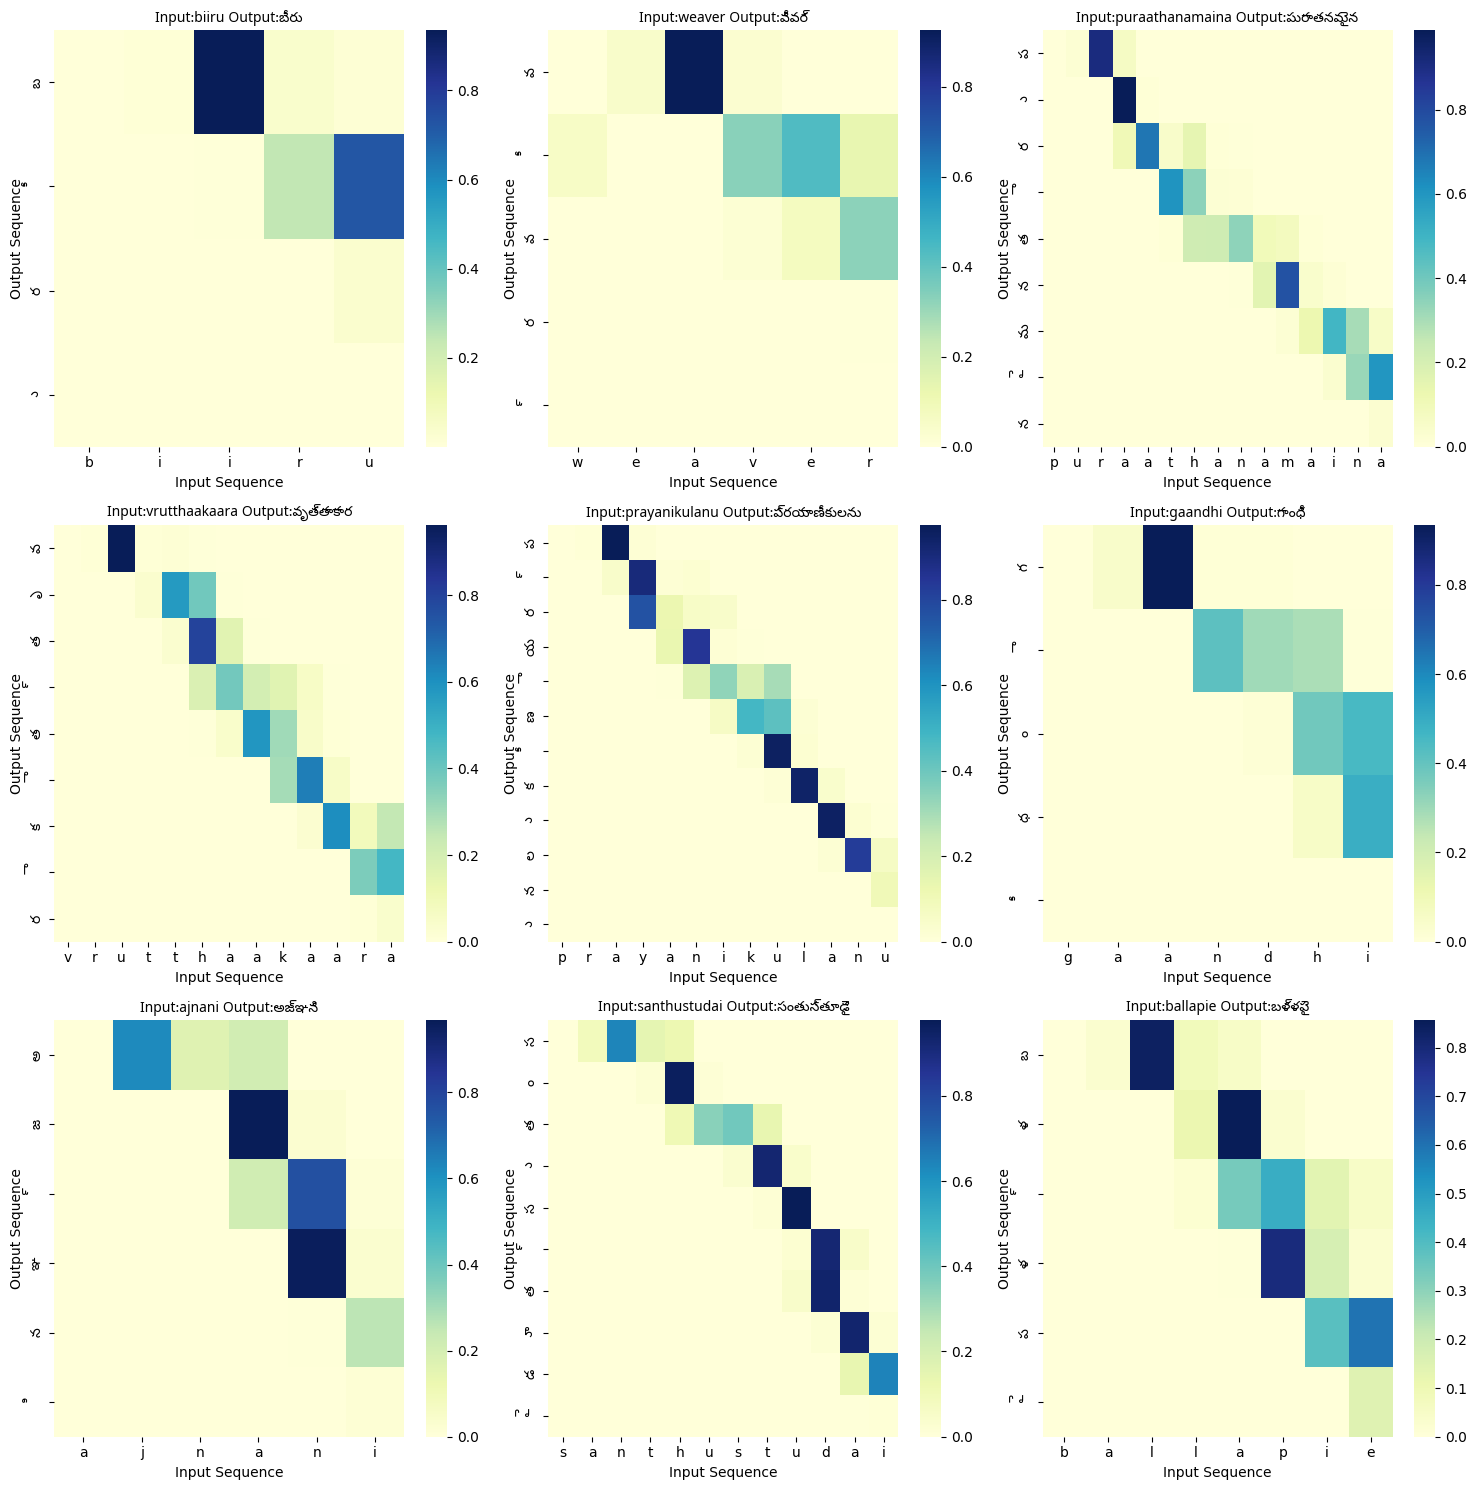

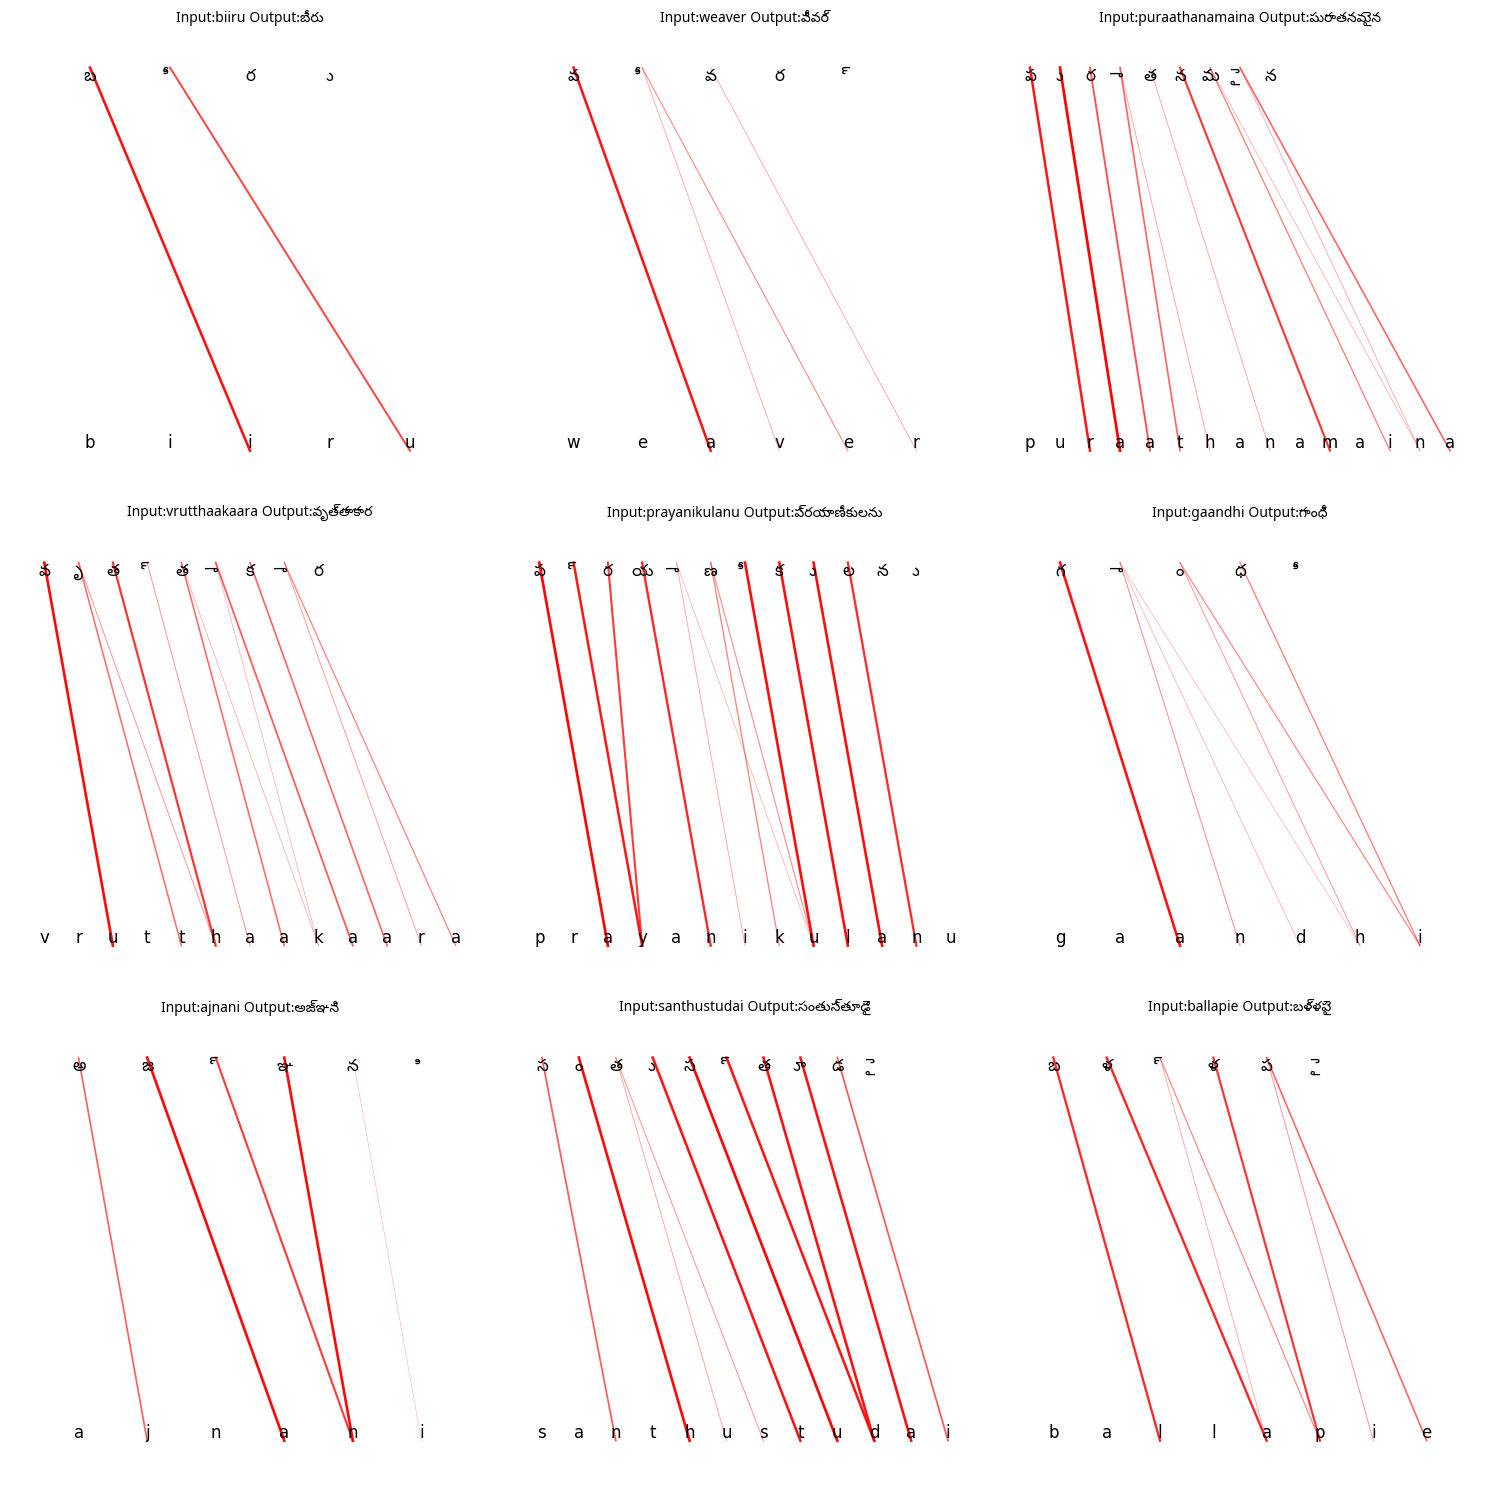

In [28]:
test_and_evaluate(best_run_config)